# How To Measure Your Risk-Adjusted Returns With The Sortino Ratio
The Sortino ratio tells you the risk-adjusted return of an investment. It is similar to the Sharpe ratio except it only considers “downside deviation”. In other words, it only uses the asset’s standard deviation of negative returns. Investors consider it a better measure of an asset’s risk-adjusted performance since positive volatility is a benefit.

If you’re investing or trading, you might want to consider the Sortino ratio as one of your performance metrics.

## Without Considering The Sortino Ratio, You Miss Important Information About The Performance.
Like the Sharpe ratio, you can use the Sortino ratio to compare investments.

For example:

- Stock A returns 30% with 20% volatility and 30% downside deviation
- Stock B returns 20% with 13% volatility and 15% downside deviation
Which is the better investment?

Both stocks have the same Sharpe ratios. Stock B’s return is lower but so is the downside deviation. That means stock A has more volatility in its negative returns and is riskier than stock B. The Sortino ratio captures this dynamic.

Here's what we'll do:

1. Get stock price data
2. Compute the Sortino ratio
3. Compute downside deviation
4. Compare two investment options


## Step 1: Get The Data
Start by importing the libraries and getting the data. I like to use yfinance for getting stock data and NumPy for vectorizing outputs.

In [1]:
import numpy as np
import pandas as pd

from openbb_terminal.sdk import openbb

With yfinance, you can download data for more than one stock at a time. Grab data for both SPY and AAPL.

In [2]:
closes = openbb.economy.index(["SPY", "AAPL"], start_date="2020-01-01", end_date="2022-07-31")

In [3]:
spy_returns = closes.SPY.pct_change().dropna()
aapl_returns = closes.AAPL.pct_change().dropna()

## Step 2: Compute The Sortino Ratio
A function for the Sortino ratio in Python is straightforward

In [4]:
def sortino_ratio(returns, adjustment_factor=0.0):
    """
    Determines the Sortino ratio of a strategy.
    
    Parameters
    ----------
    returns : pd.Series or np.ndarray
        Daily returns of the strategy, noncumulative.
    adjustment_factor : int, float
        Constant daily benchmark return throughout the period.

    Returns
    -------
    sortino_ratio : float

    Note
    -----
    See `<https://www.sunrisecapital.com/wp-content/uploads/2014/06/Futures_
    Mag_Sortino_0213.pdf>`__ for more details.
    """

    # compute annualized return
    returns_risk_adj = np.asanyarray(returns - adjustment_factor)
    average_annual_return = returns_risk_adj.mean() * 252

    # compute download deviation
    downside_diff = np.clip(returns_risk_adj, np.NINF, 0)
    np.square(downside_diff, out=downside_diff)
    annualized_downside_deviation = np.sqrt(downside_diff.mean()) * np.sqrt(252)

    return average_annual_return / annualized_downside_deviation

The function takes a series of daily returns and subtracts an adjustment factor. Some investors use this to measure the return over the risk-free rate. Since the risk free-rate has been near 0 for almost a decade, I don’t consider it in the analysis. Finally, take the average return and annualize it.

To compute downside deviation, I use the clip function. The clip returns the numbers in an array between two values. I take the negative returns by using negative infinity and 0. Then I find the standard deviation of the negative returns and annualize it.

The Sortino ratio is the average annualized return divided by the annualized downside deviation.

#### A note on downside deviation

“Risk” usually refers to the volatility of an asset. That’s because the higher the volatility the higher the uncertainty of where the price will be when you want to sell the asset. When most people think of risk, they usually think of how much money they might lose. Downside deviation attempts to capture the “money-losing” part of the asset volatility.

## Step 3: Compare Investment Options
Compute the Sortino ratio for AAPL and SPY.

In [5]:
sortino_ratio(spy_returns)

0.7591405571472791

In [6]:
sortino_ratio(aapl_returns)

1.4980848446848376

The Sortino ratio for AAPL is higher than for SPY. That means you got more return for every unit of downside risk.

It’s always useful to look at performance metrics through time because they are never static. It’s easy with Python.

<AxesSubplot:xlabel='Date'>

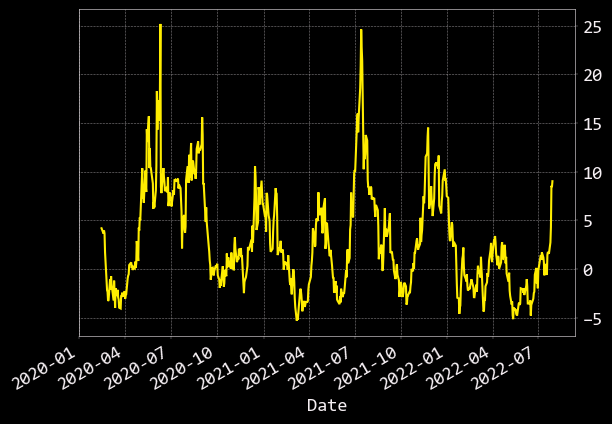

In [7]:
aapl_returns.rolling(30).apply(sortino_ratio).plot()

Use a histogram to visualize the distribution of rolling Sortino ratios. In the case of AAPL, there is a long tail of positive Sortino ratios.



<AxesSubplot:>

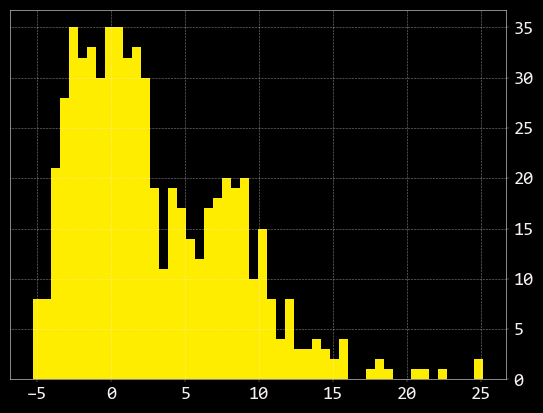

In [8]:
aapl_returns.rolling(30).apply(sortino_ratio).hist(bins=50)

Finally, let’s see how the Sortino ratios of AAPL and SPY compare through time. Was AAPL always a better risk adjusted return?

Subtract the SPY Sortino ratio from the AAPL Sortino ratio and plot the result as a histogram.



<AxesSubplot:>

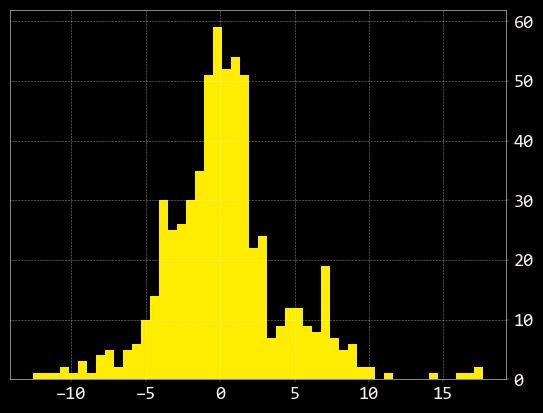

In [9]:
(
    aapl_returns.rolling(30).apply(sortino_ratio)
    - spy_returns.rolling(30).apply(sortino_ratio)
).hist(bins=50)

In [10]:
sortino_ratio(spy_returns)

0.7591405571472791

The histogram looks like two overlapping distributions. One distribution is centered around 0 and looks to be skewed left. The other distribution looks to center around 5 and be more even. This might reflect two different periods of time. One where SPY outperformed AAPL and another where AAPL outperformed SPY.

Without the Sortino ratio, you might miss this important information about performance.

